# Tutorial 4: Two-Mark Chromatin

In `tutorial_3`, we walked through the simulation of a chromatin fiber with a single epigenetic mark and reader protein. In this notebook, we will add a second epigenetic mark and reader protein to the system. Descriptions in this notebook will highlight differences between simulations with one and two epigenetic marks. 

|

#### Import Modules

All modules are the same as seen in `tutorial_3`.

In [1]:
# Built-in modules
import os
import sys
from inspect import getmembers, isfunction

# Third-party modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Custom modules
from chromo.binders import get_by_name, make_binder_collection
from chromo.polymers import Chromatin
from chromo.fields import UniformDensityField
import chromo.mc as mc
import chromo.mc.mc_controller as ctrl
from chromo.util.reproducibility import get_unique_subfolder_name
import chromo.util.mu_schedules as ms

|

#### Specify Binders

We will simulate a chromatin fiber with two key, repressive histone marks: H3K9me3 and H3K27me3. These epigenetic marks are preferentially bound by HP1 and PRC1 readers, respectively. Both reader proteins can be instantiated by name, as shown below.

In [2]:
# Instantiate HP1 and PRC1 reader proteins
hp1 = get_by_name('HP1')
prc1 = get_by_name('PRC1')

You can modify the concentrations, self-interaction strengths, and cross-interaction strengths of these readers. To avoid double-counting the cross-interaction energy between the two reader proteins, only specify the cross-interaction energy for the first reader in the pair (as ordered in the binder collection).

In [3]:
# Set the HP1-PRC1 cross interaction to 1.0 kT
hp1.cross_talk_interaction_energy["PRC1"] = 1.0

# Set the HP1 and PRC1 chemical potentials to -1.2 kT
hp1.chemical_potential = -1.2
prc1.chemical_potential = -1.2

In [4]:
# Create a binder collection with the HP1 and PRC1 reader proteins
binder_collection = make_binder_collection([hp1, prc1])

|

#### Specify the Confinement

In [5]:
confine_type = "Spherical"
confine_radius = 200.0

|

#### Instantiate Epigenetic Mark Pattern

To add a second epigenetic mark, we will add a second column to our numpy array of mark patterns. We will mark the first half of the chromatin fiber with H3K9me3 and the second half of the chromatin fiber with H3K27me3.

In [6]:
num_beads = 1000
mark_pattern = np.zeros((num_beads, 2), dtype=int)
mark_names = np.array(["H3K9me3", "H3K27me3"])
mark_pattern[:500, 0] = 2
mark_pattern[500:, 1] = 2
print("Shape of mark pattern:", mark_pattern.shape)

Shape of mark pattern: (1000, 2)


|

#### Specify Initial Reader Protein Binding States

Again, we will assume that no reader proteins are bound to the chromatin fiber. This time, we will add a second column to our reader protein binding states array to represent PRC1.

In [7]:
binder_names = np.array([hp1.name, prc1.name])
states = np.zeros((num_beads, 2), dtype=int)

|

#### Instantiate the Polymer

In [8]:
# Specify the name, number of beads, and bead spacing of the chromatin fiber
name = "Chr"
bead_spacing = np.ones(num_beads - 1) * 16.5

# Instantiate the chromatin fiber
poly = Chromatin.confined_gaussian_walk(
    name,
    num_beads,
    bead_spacing,
    confine_type=confine_type,
    confine_length=confine_radius,
    states=states,
    binder_names=binder_names,
    chemical_mods=mark_pattern,
    chemical_mod_names=mark_names
)

|

#### Specify the Uniform Density Field

In [9]:
 # Specify the dimensions of the field
n_accessible = int(np.round((63 * confine_radius) / 900))
n_buffer = 2
n_bins_x = n_accessible + n_buffer
x_width = 2 * confine_radius * (1 + n_buffer/n_accessible)
n_bins_y = n_bins_x
y_width = x_width
n_bins_z = n_bins_x
z_width = x_width

# Initialize the uniform density field
udf = UniformDensityField(
    [poly],
    binder_collection,
    x_width,
    n_bins_x,
    y_width,
    n_bins_y,
    z_width,
    n_bins_z,
    confine_type=confine_type,
    confine_length=confine_radius,
    chi=1,
    assume_fully_accessible=1,
    fast_field=0
)

|

#### Specify the Simulation Parameters

In [10]:
amp_bead_bounds, amp_move_bounds = mc.get_amplitude_bounds(
    polymers = [poly]
)

In [11]:
num_snapshots = 200
mc_steps_per_snapshot = 1000

In [12]:
# Create a list of simulated annealing schedules, which are defined in another file
schedules = [func[0] for func in getmembers(ms, isfunction)]

# Select a schedule for slowly adding HP1 into the system
select_schedule = "linear_step_for_negative_cp"
mu_schedules = [
    ms.Schedule(getattr(ms, func_name)) for func_name in schedules
]
mu_schedules = [sch for sch in mu_schedules if sch.name == select_schedule]

|

#### Run the Simulation

In [ ]:
# Specify the output directory
out_dir = "output_demo"

# Run the simulation
polymers = mc.polymer_in_field(
    [poly],
    binder_collection,
    udf,
    mc_steps_per_snapshot,
    num_snapshots,
    amp_bead_bounds,
    amp_move_bounds,
    output_dir=out_dir,
    mu_schedule=mu_schedules[0],
)

|

#### Plot the Resulting Configuration

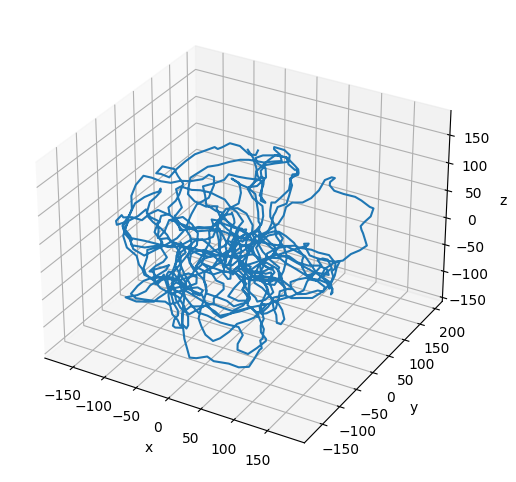

In [14]:
# Plot the final configuration of the polymer
x = polymers[0].r[:, 0]
y = polymers[0].r[:, 1]
z = polymers[0].r[:, 2]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')
ax.plot3D(np.asarray(x), np.asarray(y), np.asarray(z))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()